In [141]:
import exoplanet
import numpy as np
import matplotlib.pyplot as plt
import exoplanet as xo
import pymc3 as pm
import pymc3_ext as pmx
import arviz as az
from astropy import constants as c

In [142]:
data = np.load("data.npy")
ts = data[:,0]
ts = ts - ts[0]
ys = data[:,1]
yerrs = data[:,2]

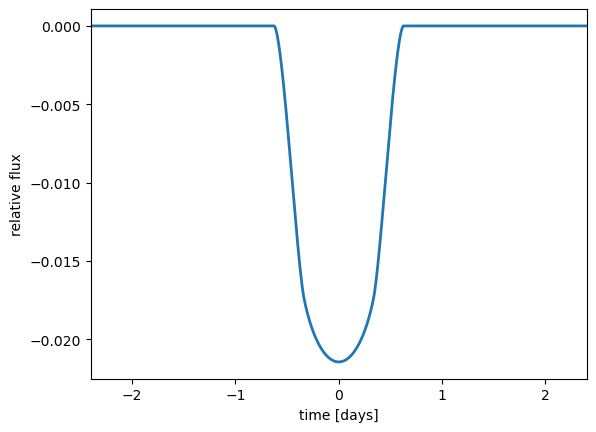

In [143]:
# The light curve calculation requires an orbit
orbit = xo.orbits.KeplerianOrbit(period=0.813475, b=0.698, r_star=0.667, m_star=0.58)

# Compute a limb-darkened light curve using starry
t = np.linspace(-0.1, 0.1, 1000)
u = [0.6012, 0.1492]
light_curve = (
    xo.LimbDarkLightCurve(*u)
    .get_light_curve(orbit=orbit, r=0.095569297, t=t)
    .eval()
)
# Note: the `eval` is needed because this is using Theano in
# the background
plt.figure()
t = t*24
plt.plot(t, light_curve, color="C0", lw=2)
plt.ylabel("relative flux")
plt.xlabel("time [days]")
_ = plt.xlim(t.min(), t.max())

In [165]:
np.random.seed(123)
periods = 0.813477
t0s = 0.05
t = np.linspace(0, 0.1, 1000)
yerr = 0.00001

In [166]:
with pm.Model() as model:
    # The baseline flux
    mean = pm.Normal("mean", mu=1.0, sd=0.5)

    # The time of a reference transit for each planet
    t0 = pm.Normal("t0", mu=t0s, sd=0.1)

    # The log period; also tracking the period itself
    logP = pm.Normal("logP", mu=np.log(periods), sd=1)
    period = pm.Deterministic("period", pm.math.exp(logP))

    # The Kipping (2013) parameterization for quadratic limb darkening paramters
    u = ([0.6012, 0.1492])
    r = pm.Uniform(
        "r", lower=0.06, upper=0.12, testval=0.095569297
    )
    b = xo.distributions.ImpactParameter(
        "b", ror=r, testval=0.698
    )
    
    # Set up a Keplerian orbit for the planets
    orbit = xo.orbits.KeplerianOrbit(period=period, t0=t0, b=b, r_star=0.667, m_star=0.58)

    # Compute the model light curve using starry
    light_curves = xo.LimbDarkLightCurve(u[0], u[1]).get_light_curve(
        orbit=orbit, r=r, t=t
    )
    light_curve = pm.math.sum(light_curves, axis=-1) + mean

    # Here we track the value of the model light curve for plotting
    # purposes
    pm.Deterministic("light_curves", light_curves)

    # ******************************************************************* #
    # On the folowing lines, we simulate the dataset that we will fit     #
    #                                                                     #
    # NOTE: if you are fitting real data, you shouldn't include this line #
    #       because you already have data!                                #
    # ******************************************************************* #
    y = pmx.eval_in_model(light_curve)
    y += yerr * np.random.randn(len(y))
    # ******************************************************************* #
    # End of fake data creation; you want to include the following lines  #
    # ******************************************************************* #
    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=light_curve, sd=yerr, observed=y)

    # Fit for the maximum a posteriori parameters given the simuated
    # dataset
    map_soln = pmx.optimize(start=model.test_point)

optimizing logp for variables: [b, r, logP, t0, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: 10089.76950426965 -> 10094.328771002585


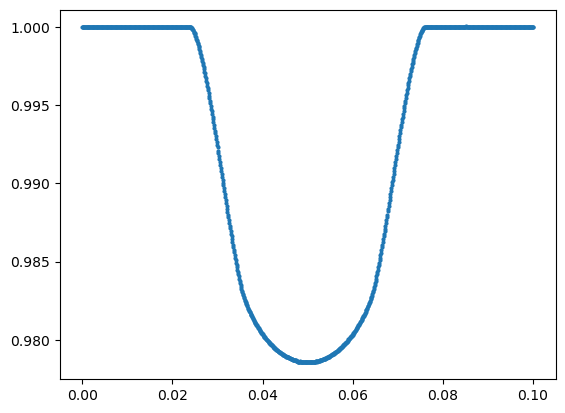

In [167]:
plt.scatter(t,y,s = 4)

In [171]:
np.save("anim.npy",np.array([t,y,np.zeros_like(y)]))

In [137]:
np.random.seed(42)
with model:
    trace = pmx.sample(
        tune=1000,
        draws=1000,
        start=map_soln,
        cores=1,
        chains=2,
        target_accept=0.9,
        return_inferencedata=True,
    )

Sequential sampling (2 chains in 1 job)
NUTS: [b, r, logP, t0, mean]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 57 seconds.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


In [138]:
az.summary(trace, var_names=["period", "t0", "r", "b", "mean"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
period,0.919,0.466,0.104,1.692,0.073,0.052,29.0,100.0,1.06
t0,0.047,0.006,0.033,0.056,0.001,0.001,19.0,56.0,1.09
r,0.093,0.003,0.088,0.097,0.000,0.000,212.0,124.0,1.01
b,0.342,0.211,0.007,0.704,0.041,0.037,29.0,135.0,1.08
mean,1.000,0.000,0.999,1.000,0.000,0.000,619.0,723.0,1.00


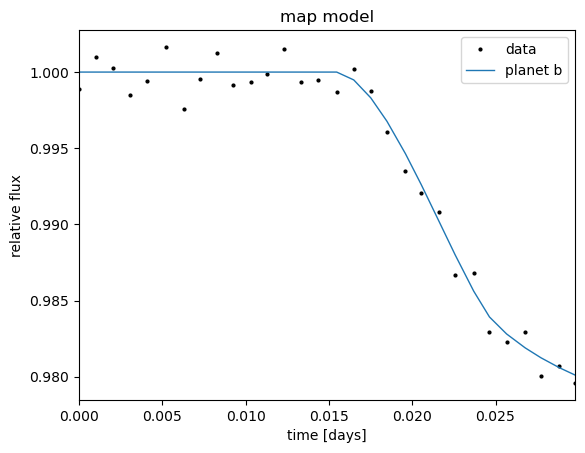

In [139]:
plt.figure()
plt.plot(t, y, ".k", ms=4, label="data")
for i, l in enumerate("b"):
    plt.plot(
        t, 1+map_soln["light_curves"][:, i], lw=1, label="planet {0}".format(l)
    )
plt.xlim(t.min(), t.max())
plt.ylabel("relative flux")
plt.xlabel("time [days]")
plt.legend(fontsize=10)
# plt.xlim(0,10)
_ = plt.title("map model")

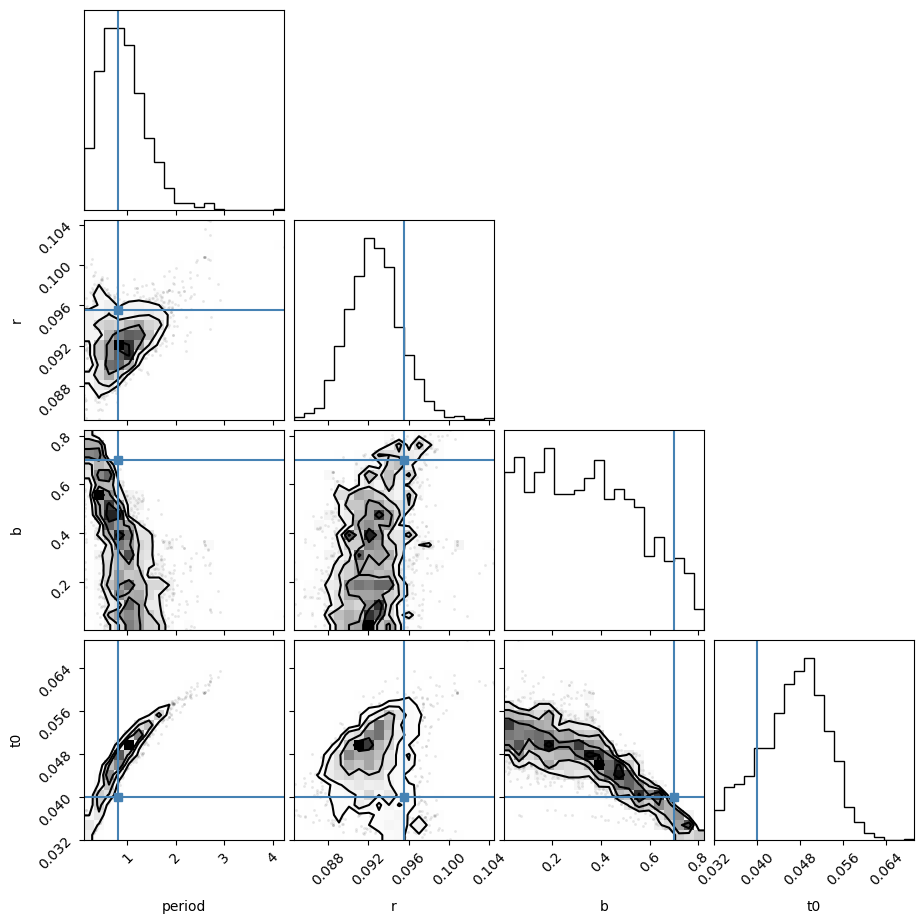

In [140]:
import corner

truth = dict(
    zip(
        ["period", "r","b","t0"],
        pmx.eval_in_model([period, r,b,t0], model.test_point, model=model),
    )
)
_ = corner.corner(
    trace,
    var_names=["period", "r","b","t0"],
    truths=truth,
)